### Patrycja Wysocka, 306 022

In [39]:
from scipy.io import loadmat
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import RocCurveDisplay
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import OneClassSVM
from statistics import mean
from matplotlib import pyplot as plt
from kneed import KneeLocator
from collections import Counter
from sklearn.metrics import f1_score

import genieclust
import numpy as np
import seaborn as sns
import os
import warnings

warnings.filterwarnings("ignore")

In [2]:
DATASET_DIR = './datasets/'

### Import datasets

.mat files

In [3]:
# @TODOL import all datasets
directory = os.fsencode(DATASET_DIR)
datasets = []
datasets_names = []
outliers_number = []

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename[:-3] != 'mat':
        continue
    data = loadmat(DATASET_DIR + filename)
    print(f"name: {filename[:-4]},\t\t y values: {np.unique(data['y'])},\t nr of variables: {data['X'].shape[1]}")
    datasets_names.append(filename[:-4])
    X, y = data['X'], data['y']
    outliers_number.append(np.count_nonzero(y == 1))
    datasets.append([X, y])

name: vowels,		 y values: [0. 1.],	 nr of variables: 12
name: lympho,		 y values: [0. 1.],	 nr of variables: 18
name: cardio,		 y values: [0. 1.],	 nr of variables: 21
name: glass,		 y values: [0. 1.],	 nr of variables: 9
name: letter,		 y values: [0 1],	 nr of variables: 32
name: thyroid,		 y values: [0. 1.],	 nr of variables: 6
name: speech,		 y values: [0 1],	 nr of variables: 400
name: satimage-2,		 y values: [0. 1.],	 nr of variables: 36
name: musk,		 y values: [0. 1.],	 nr of variables: 166
name: wbc,		 y values: [0. 1.],	 nr of variables: 30


In [4]:
accuracies = []

### Helper functions

In [5]:
def show_acc(results):
    all_acc = []

    print("** Accuracy score **\n")
    for data, y_pred, name in zip(datasets, results, datasets_names):
        X, y_true = data
        acc = accuracy_score(y_true, y_pred)
        print(f'{name}: {round(acc*100, 2)}%')
        all_acc.append(acc)

    mean_acc = mean(all_acc)
    print(f'\nmean accuracy: {round(mean_acc, 2)*100}%')

    sns.barplot(x=datasets_names, y=all_acc, hue=datasets_names, legend=False).set_title("Accuracy score")
    plt.xticks(rotation=45);
    
    return mean_acc

In [6]:
def mean_precision(results):
    all_precision = []

    for data, y_pred in zip(datasets, results):
        X, y_true = data
        acc = precision_score(y_true, y_pred, zero_division=True)
        all_precision.append(acc)
    
    return mean(all_precision)

In [7]:
def mean_recall(results):
    all_recall = []

    for data, y_pred in zip(datasets, results):
        X, y_true = data
        acc = recall_score(y_true, y_pred, zero_division=True)
        all_recall.append(acc)
    
    return mean(all_recall)

In [27]:
def mean_f1_scores(results):
    all_f1_scores = []

    for data, y_pred in zip(datasets, results):
        X, y_true = data
        acc = f1_score(y_true, y_pred, zero_division=True)
        all_f1_scores.append(acc)
    
    return mean(all_f1_scores)

### DBSCAN

Since this algorithm is very sensitive for the values of `epsilon` and `min_points`, I decided to set value `min_points` as twice the dimension of dataset, or at least with the following formula: `min_points >= dimensions + 1`. Value of `epsilon` will be caluclated using `K-distance graph`. Here is just visualisation on a single example what we'll be happening inside the function, when it comes to optimialization of the parameters.

The optimum value of `epsilon`  is at the point of maximum curvature in the `K-Distance Graph`

In [8]:
X, y = datasets[0]

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

Best epsilon: 1.5761321290968398


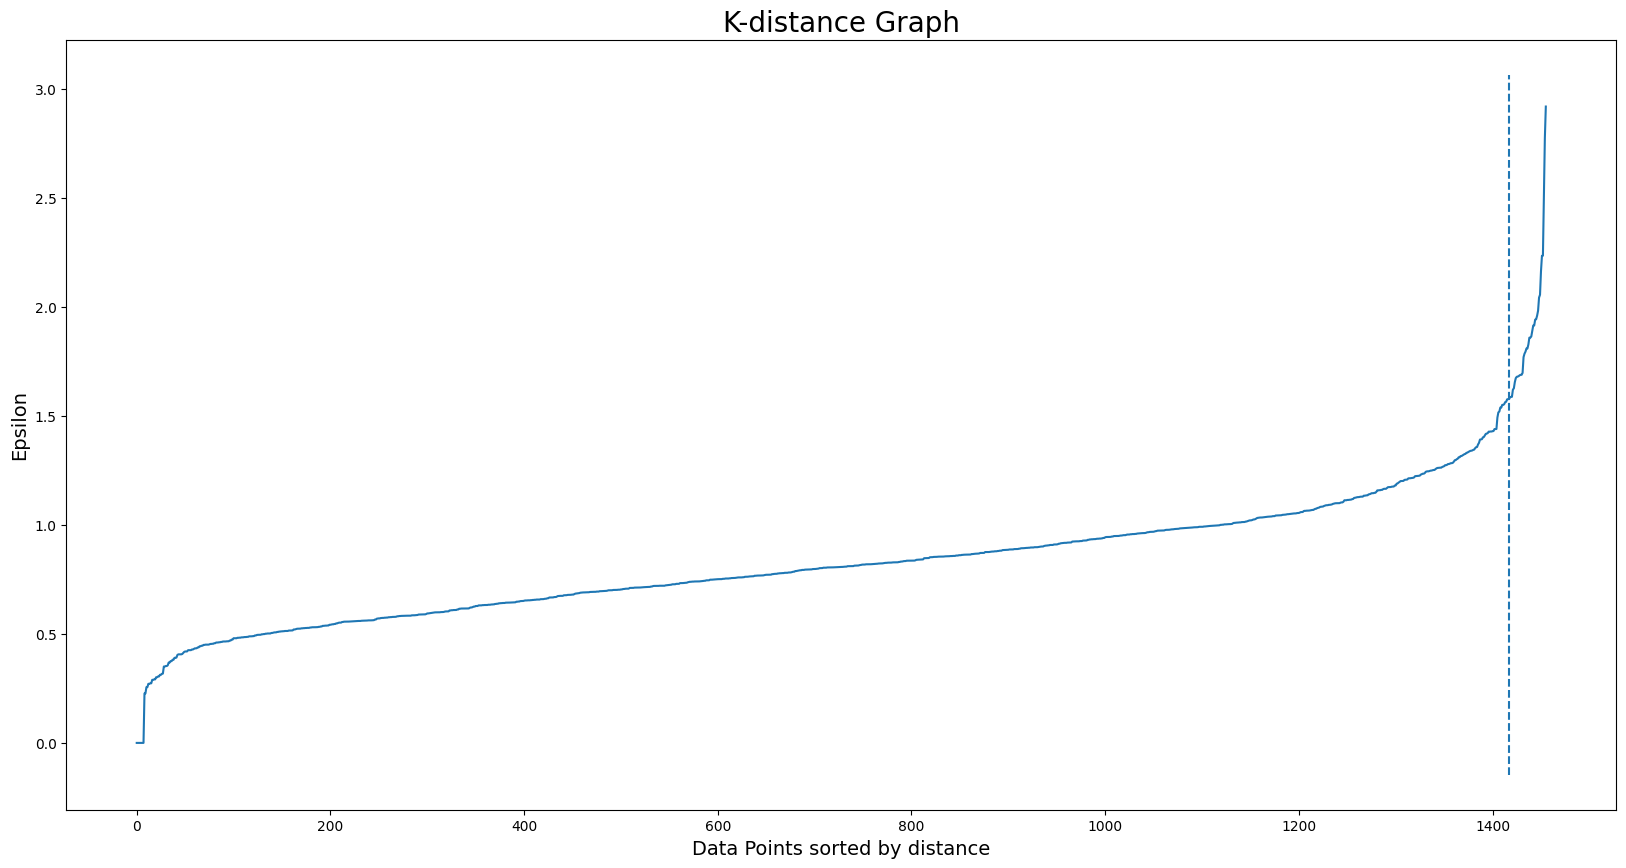

In [9]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]

y = list(range(0, len(distances)))
kn = KneeLocator(y, distances, curve='convex', direction='increasing')

print(f'Best epsilon: {kn.knee_y}')

plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

One more plot from the original library:

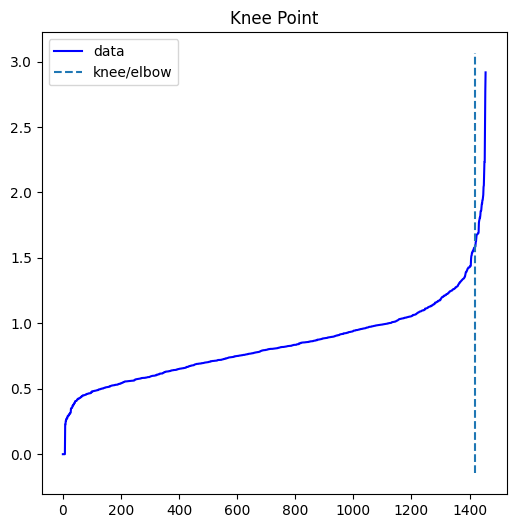

In [10]:
kn.plot_knee()

In [11]:
dbscan_results = []

for X, y in datasets:
    # Optimalization
    # min points
    min_points = X.shape[1] * 2
    
    # epsilon
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]

    kn = KneeLocator(list(range(0, len(distances))), distances, curve='convex', direction='increasing')
    eps = kn.knee_y
    
    #algorithm
    dbscan = DBSCAN(min_samples=min_points, eps=eps).fit(X)
    res = [1 if el == -1 else 0 for el in dbscan.labels_]
    dbscan_results.append(res)

** Accuracy score **

vowels: 55.49%
lympho: 32.43%
cardio: 84.6%
glass: 72.43%
letter: 79.62%
thyroid: 97.53%
speech: 91.16%
satimage-2: 95.71%
musk: 3.17%
wbc: 91.27%

mean accuracy: 70.0%


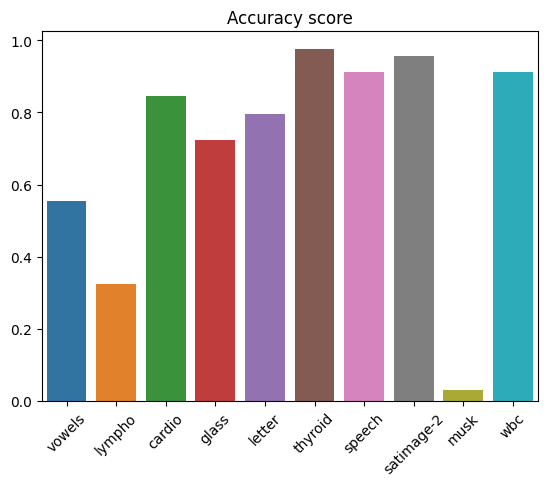

In [12]:
accuracies.append(show_acc(dbscan_results))  # previously: 27 % !!!!!

## HDBSCAN

In [13]:
hdbscan_results = []

for X, y in datasets:
    hdbscan = HDBSCAN().fit(X)
    res = [1 if el == -1 else 0 for el in hdbscan.labels_]
    hdbscan_results.append(res)

** Accuracy score **

vowels: 89.15%
lympho: 83.78%
cardio: 90.39%
glass: 77.57%
letter: 71.88%
thyroid: 17.5%
speech: 17.53%
satimage-2: 97.31%
musk: 96.83%
wbc: 5.56%

mean accuracy: 65.0%


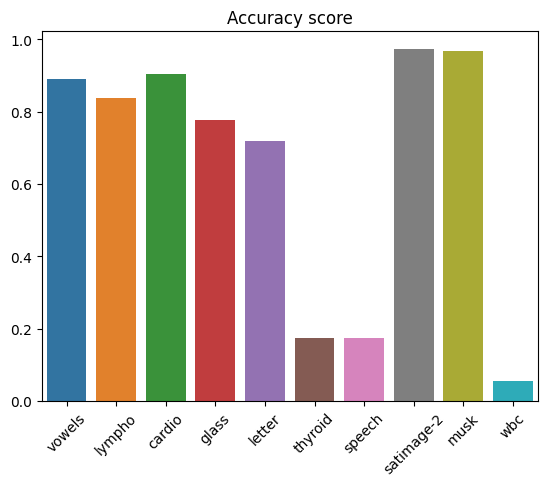

In [14]:
accuracies.append(show_acc(hdbscan_results));

## One class SVM

In [15]:
svm_results = []

for X, y in datasets:
    clf = OneClassSVM(nu=0.1).fit(X)
    res = [1 if el == -1 else 0 for el in clf.predict(X)]
    svm_results.append(res)

** Accuracy score **

vowels: 89.01%
lympho: 91.22%
cardio: 87.98%
glass: 86.92%
letter: 86.38%
thyroid: 90.88%
speech: 89.01%
satimage-2: 91.21%
musk: 90.76%
wbc: 89.68%

mean accuracy: 89.0%


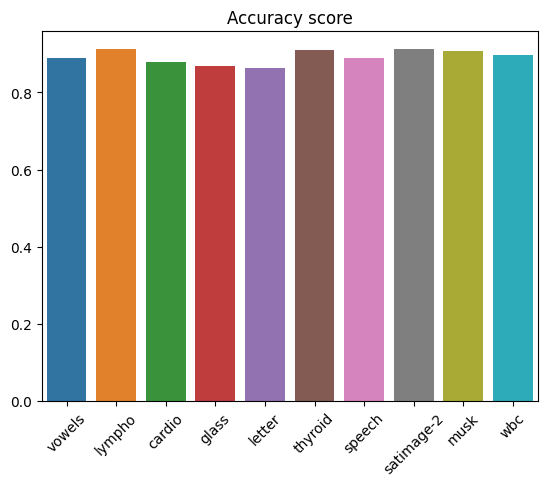

In [16]:
accuracies.append(show_acc(svm_results));

## Isolation Forest

In [17]:
isolation_forest_results = []

for X, y in datasets:
    clf = IsolationForest().fit(X)
    res = [1 if el == -1 else 0 for el in clf.predict(X)]
    isolation_forest_results.append(res)

** Accuracy score **

vowels: 90.18%
lympho: 68.24%
cardio: 88.48%
glass: 87.85%
letter: 88.44%
thyroid: 92.26%
speech: 98.21%
satimage-2: 91.97%
musk: 93.31%
wbc: 93.12%

mean accuracy: 89.0%


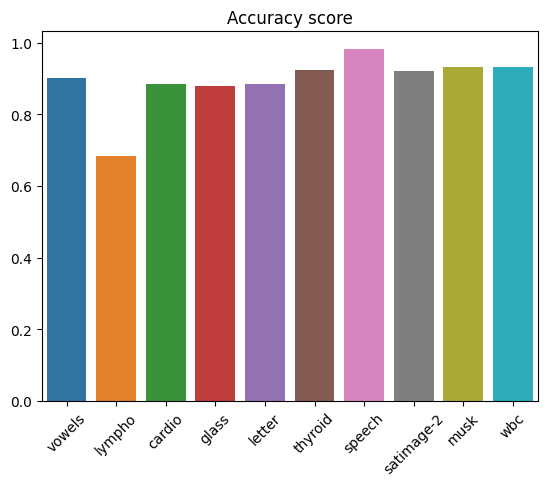

In [18]:
accuracies.append(show_acc(isolation_forest_results));

## Local Outlier Factor

In [19]:
loc_results = []

for X, y in datasets:
    clf = LocalOutlierFactor()
    res = [1 if el == -1 else 0 for el in clf.fit_predict(X)]
    loc_results.append(res)

** Accuracy score **

vowels: 96.43%
lympho: 95.95%
cardio: 89.24%
glass: 84.11%
letter: 94.19%
thyroid: 94.83%
speech: 98.35%
satimage-2: 96.78%
musk: 96.83%
wbc: 92.86%

mean accuracy: 94.0%


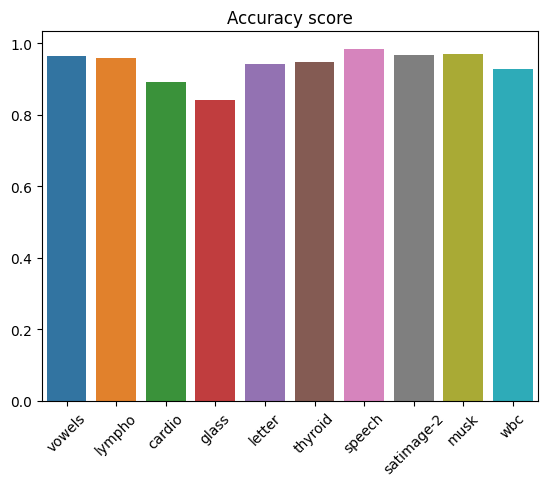

In [20]:
accuracies.append(show_acc(loc_results));

## Genie

In [21]:
genie_results = []

# @TODO: explore n_cluster and M value
for X, y in datasets:
    g = genieclust.Genie(n_clusters=2)
    res = [1 if el == -1 else 0 for el in g.fit_predict(X)]
    genie_results.append(res)

** Accuracy score **

vowels: 96.57%
lympho: 95.95%
cardio: 90.39%
glass: 95.79%
letter: 93.75%
thyroid: 97.53%
speech: 98.35%
satimage-2: 98.78%
musk: 96.83%
wbc: 94.44%

mean accuracy: 96.0%


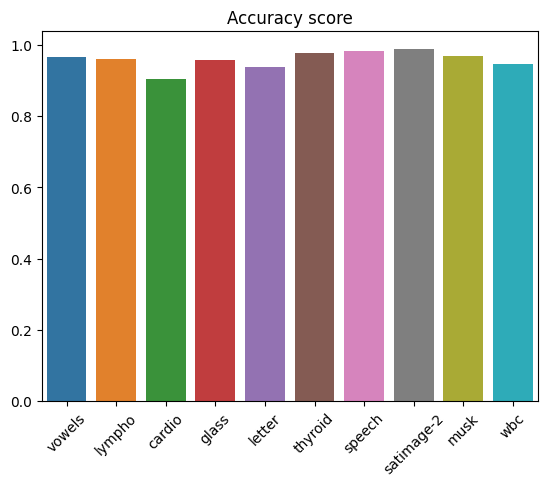

In [22]:
accuracies.append(show_acc(genie_results));

### Results and summary

In [28]:
results = [dbscan_results, hdbscan_results, svm_results, isolation_forest_results, loc_results, genie_results]
models = ['DBSCAN', 'HDBSCAN', 'OneClassSVM', 'IsolationForest', 'LocalOutlierFactor', 'Genie']

precisions = [mean_precision(res) for res in results]
recalls = [mean_recall(res) for res in results]
f1_scores = [mean_f1_scores(res) for res in results]

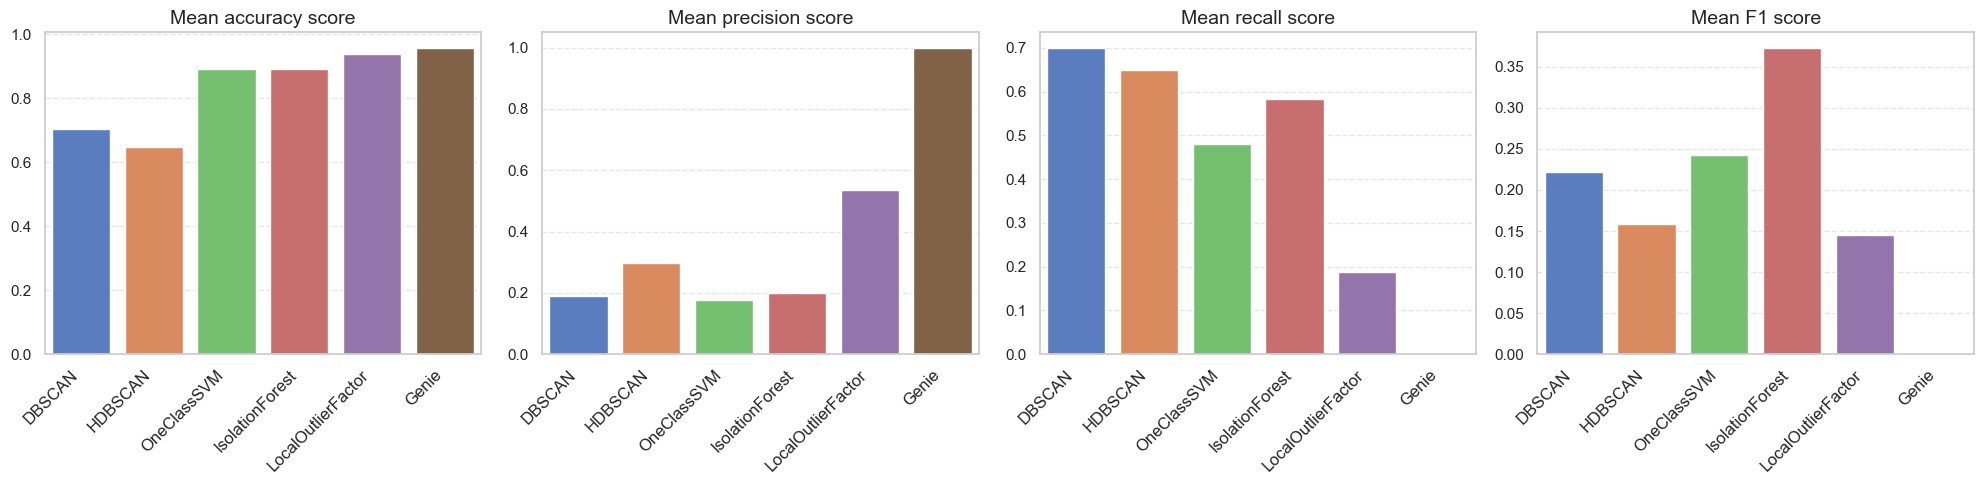

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

values = [accuracies, precisions, recalls, f1_scores]
metrics = ['Mean accuracy score', 'Mean precision score', 'Mean recall score', 'Mean F1 score']

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, value in enumerate(values):
    sns.barplot(x=models, y=value, ax=axs[i], palette="muted")  
    axs[i].set_title(metrics[i], fontsize=14) 
    axs[i].set_xticklabels(models, rotation=45, ha='right', fontsize=12)  
    axs[i].grid(axis='y', linestyle='--', alpha=0.5)  
plt.tight_layout()  
plt.show()
